In [26]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pickle # para leer los archivos comprimidos (.p)

###parameters######################
COM_ARDUINO_UNO = 'COM7'
baudrate_arduino= 250000#115200 #250000 #
SampleFreq=2000 #Hz
tiempo_adq = 40 #seg
nombreArchivo = './mediciones/24102023_a1_120-mano-lev.p'# nombre del archivo donde guardar los datos
nsensores =2 # 1 a 4
arduino_serial_plotter_protocol_on = 0 # data sent using arduino serial protocol (ascii for each digit) or send raw bytes

################################################

cantidad_samples = SampleFreq*tiempo_adq   #1min 120 000

def leer_sensor(arduino_puerto_serie,cantidad_samples):
    samples_sensor0 = np.zeros((cantidad_samples))
    #samples_sensor1 = np.zeros((cantidad_samples))
    #samples_sensor2 = np.zeros((cantidad_samples))
    if nsensores >= 2 :
        samples_sensor1 = np.zeros((cantidad_samples))
    if nsensores >= 3 :
        samples_sensor2 = np.zeros((cantidad_samples))                         
    if nsensores >= 4 :
        samples_sensor3 = np.zeros((cantidad_samples)) 
    i = 0
    arduino.reset_input_buffer()
    for n_samples in range(0,cantidad_samples):
        read_val = False
        splitted = ""
        while not read_val:
            try:
                if arduino_serial_plotter_protocol_on == 0:
                    line = arduino.read(nsensores*3) #nbytes= 3bytes x sensor( 2bytes datos+1 de coma o de /n el ultimo)
                    if len(line) == nsensores*3 :
                        samples_sensor0[n_samples] = float(line[1] + 256*line[0])
                        if nsensores >= 2 :
                            samples_sensor1[n_samples] = float(line[4] + 256*line[3]) 
                        if nsensores >= 3 :
                            samples_sensor2[n_samples] = float(line[7] + 256*line[6])                         
                        if nsensores >= 4 :
                            samples_sensor3[n_samples] = float(line[10] + 256*line[9])                         
                        #samples_sensor1[n_samples] = float(line[4] + 256*line[3])
                        #samples_sensor2[n_samples] = float(line[7] + 256*line[6])
                        read_val = True
                    else:
                        print("SYNCHRONIZING COMMUNICATION: measuring for {}s".format(tiempo_adq))#it's ok for first data, serial read didnt receive amount of bytes as expected. data discarded")
                    line = []
                if arduino_serial_plotter_protocol_on == 1: #adquiero con formato arduino serial plotter
                    line = arduino.readline()
                    string_n = line.decode()  # decode byte string into Unicode  
                    string = string_n.rstrip() # remove \n and \r
                    string_splitted = string.split(",")
                    samples_sensor0[n_samples] = float(string_splitted[0])
                    samples_sensor1[n_samples] = float(string_splitted[1])
                    read_val = True
            except ValueError:
                print("...")
                print("Línea con error: {}".format(line))
# creo un diccionario para guardar mis datos
    if nsensores == 1 :
        samples = {'sensor0' : samples_sensor0} 
    if nsensores == 2 :
        samples = {'sensor0' : samples_sensor0,'sensor1' : samples_sensor1} 
    if nsensores == 3 :
        samples = {'sensor0' : samples_sensor0,'sensor1' : samples_sensor1, 'sensor2' : samples_sensor2} 
    if nsensores == 4 :
        samples = {'sensor0' : samples_sensor0,'sensor1' : samples_sensor1, 'sensor2' : samples_sensor2, 'sensor3' : samples_sensor3} 

    return samples #samples_sensor0, samples_sensor1, samples_sensor2


def guardar_datos(nombreArchivo, datos):
    while os.path.exists(nombreArchivo):# comprueba si el archivo existe
        print("El archivo %s ya existe. Renombrando..." %nombreArchivo)
        path = os.path.split(nombreArchivo)[0]
        raw = os.path.splitext(os.path.split(nombreArchivo)[1])[0] #nombre archivo sin extension
        ext = os.path.splitext(os.path.split(nombreArchivo)[1])[1] #extension
        nombreArchivo = os.path.join(path, raw+'_'+ext)
    with open(nombreArchivo, 'wb') as f:
        pickle.dump(datos, f)
        print("Datos guardados en %s" %nombreArchivo)
        f.close()
    return nombreArchivo

adquiriendo...
SYNCHRONIZING COMMUNICATION: measuring for 40s
Datos guardados en ./mediciones/24102023_a1_120-mano-lev.p


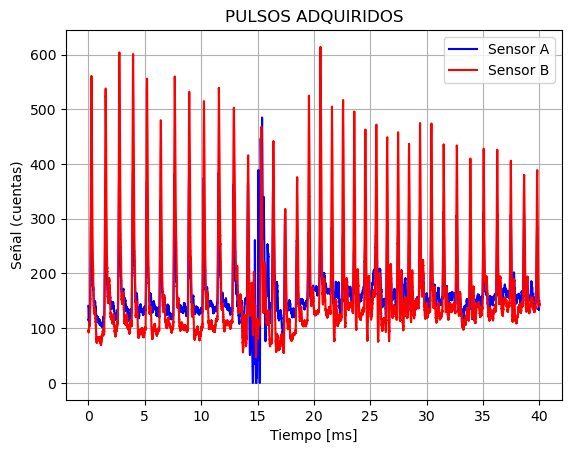

In [27]:
# Abrimos la conexión con Arduino, adquiero, y guardo
# Hack cortesía de https://www.oreilly.com/library/view/python-cookbook/0596001673/ch17s02.html
try: arduino
except NameError:
    arduino = serial.Serial(COM_ARDUINO_UNO, baudrate=baudrate_arduino, timeout=1.0)
if not arduino.is_open: arduino.open()
#arduino.setDTR(False) #reset pin
#arduino.flushInput()
#arduino.setDTR(True) #reset pin
print('adquiriendo...')
samples = leer_sensor(arduino,cantidad_samples)
arduino.close()

samples_sensor0 = samples['sensor0']
if nsensores >= 2 :
    samples_sensor1 = samples['sensor1']
if nsensores >= 3 :
    samples_sensor2 = samples['sensor2']
if nsensores >= 4 :
    samples_sensor3 = samples['sensor3']
nombreArchivo = guardar_datos(nombreArchivo, samples)

# grafico de muestras completas
time = np.arange(0,cantidad_samples/SampleFreq,1/SampleFreq)
fig = plt.figure()
plt.plot(time,samples_sensor0, 'b', label="Sensor A")
if nsensores >= 2 :
    plt.plot(time,samples_sensor1, 'r', label="Sensor B")
if nsensores >= 3 :
    plt.plot(time,samples_sensor2, 'k', label="Sensor 3")
if nsensores >= 4 :
    plt.plot(time,samples_sensor3, 'g', label="Sensor 4")

plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (cuentas)")
plt.title("PULSOS ADQUIRIDOS")
plt.legend()
#plt.xlim([1000,30000])
plt.grid()
plt.show()
